In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


## 1. Importing The Dataset
#### I started by importing only allowed libraries (e.g., NumPy, Pandas, Seaborn, Scikit-learn, XGBoost, LightGBM). These libraries support data processing, visualization, modeling, and evaluation

In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Encoding
from sklearn.base import BaseEstimator, TransformerMixin

# Modeling
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

# Custom Residual Corrector Model
from sklearn.base import RegressorMixin

# Other Utilities
from scipy.stats import skew
from urllib.parse import urlparse
import json


## 2.Loading the dataset
#### I loaded the training and test datasets using pd.read_csv(). These datasets contain customer session-level information, including timestamps, devices, locations, and purchase values.

In [3]:
train = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')

test= pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')


### Display the first few rows of the dataset

In [4]:
train .head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0


In [5]:
test.head()

,userChannel,date,browser,device.browserSize,device.browserVersion,deviceType,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,...,trafficSource,sessionId,sessionNumber,sessionStart,userId,locationZone,geoCluster,browserMajor,screenSize,gclIdPresent
0,Social,20170508,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,groups.google.com,1494262567,2,1494262567,59555,8,Region_2,not available in demo dataset,medium,0
1,Organic Search,20170405,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1491433811,1,1491433811,6394,8,Region_1,not available in demo dataset,medium,0
2,Organic Search,20170308,Safari,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1489001815,1,1489001815,38969,8,Region_5,not available in demo dataset,medium,0
3,Referral,20171113,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,docs.google.com,1510593024,30,1510593024,120027,8,Region_2,not available in demo dataset,medium,0
4,Organic Search,20161212,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,(direct),1481559809,1,1481559809,69453,8,Region_3,not available in demo dataset,medium,0


#### Detects and removes rows where purchaseValue is at its maximum.

In [6]:
max_value = train['purchaseValue'].max()


train = train[train['purchaseValue'] != max_value]
max_value

23129500000.0

#### it hepls in outlier removing and avoids overfitting

#### Checking duplicate Values

In [7]:
train.duplicated().sum()

236

In [8]:
test.duplicated().sum()

16

# Exploratory Data Analysis (EDA)
#### Exploratory Data Analysis (EDA) is a crucial step in understanding the dataset's structure, identifying patterns, and detecting anomalies. In this analysis, we will summarize key statistics, visualize distributions, and uncover potential relationships between variables.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Checking shape for both train & test dataset
print("Shape of training dataset:",train.shape)
print("Shape of test dataset:",test.shape)

# Checking unique value in traing dataset
print("Checking unique value:",train.nunique())

# Display basic information about the dataframe
print("checking basic information about training dataset:",train.info())

# Display the data types of each column
print(train.dtypes)

# Check for missing values
print("Cheking missing values:",train.isnull().sum())

# Display basic statistics for categorical columns
print("basic statistics for categorical columns:",train.describe(include=['object']))

# Display basic statistics for numerical columns
print(train.describe())

Shape of training dataset: (116021, 52)
Shape of test dataset: (29006, 51)
Checking unique value: trafficSource.isTrueDirect                           1
purchaseValue                                     6765
browser                                             34
device.screenResolution                              1
trafficSource.adContent                             53
trafficSource.keyword                              566
screenSize                                           1
geoCluster                                           5
trafficSource.adwordsClickInfo.slot                  3
device.mobileDeviceBranding                          1
device.mobileInputSelector                           1
userId                                          100499
trafficSource.campaign                              28
device.mobileDeviceMarketingName                     1
geoNetwork.networkDomain                             3
gclIdPresent                                         2
device.operatingSystem

# Data Visualization
#### Data visualization helps in understanding patterns and trends in the dataset through graphs and charts. It makes complex data easier to interpret and helps in identifying important insights quickly. Using different plots, we can compare relationships and detect any unusual patterns.


## Visualize the distribution of the target variable "purchaseValue"

#### below code snippet generates a histogram with a kernel density estimate (KDE) for the target variable, providing insights into its distribution. It helps to visualize central tendency, spread, and any potential skewness in the target data.

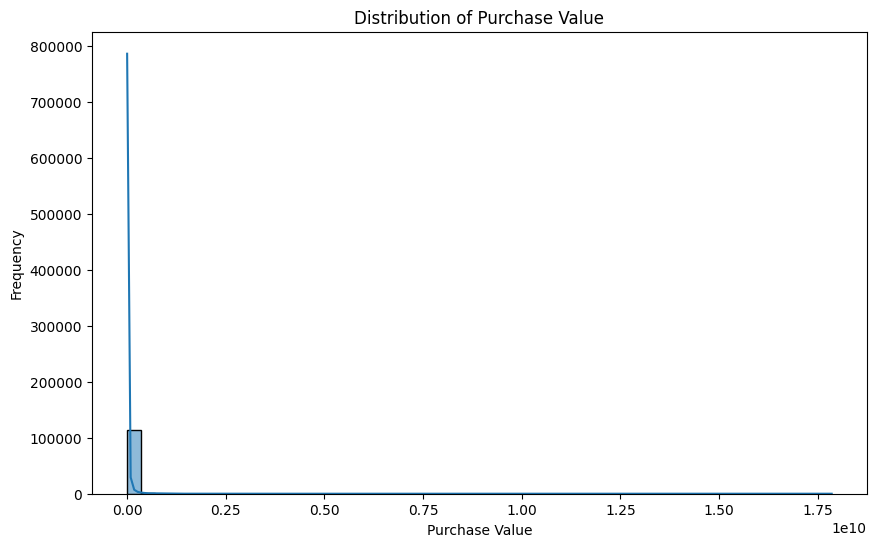

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(train['purchaseValue'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.show()

## Visualize the correlation matrix for numerical features only

#### code creates a heatmap of the correlation matrix for numerical features, giving a quick visual overview of how variables relate to each other. It helps identify highly correlated features, which might influence feature selection and model performance.

In [11]:
numerical_columns = train.select_dtypes(include=['int64','float64']).columns

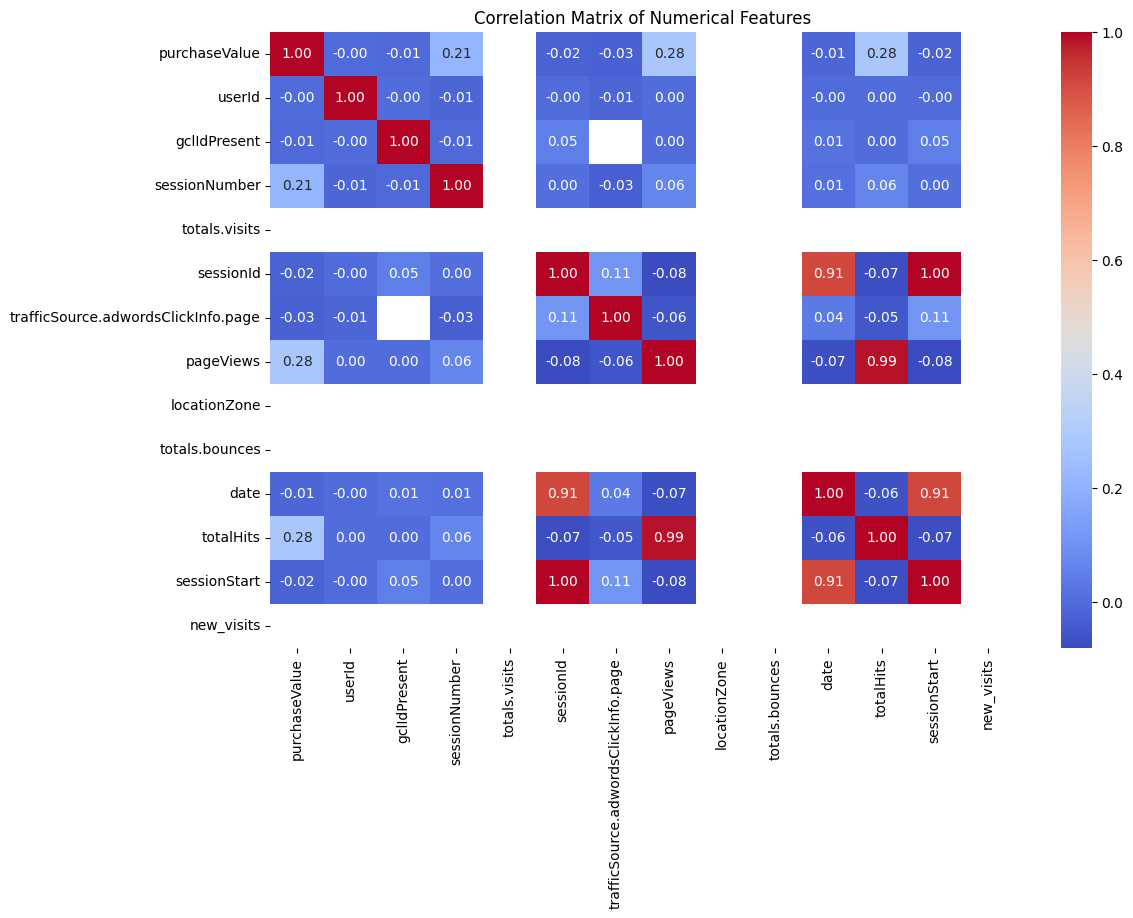

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(train[numerical_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Visualize the distribution of numerical features

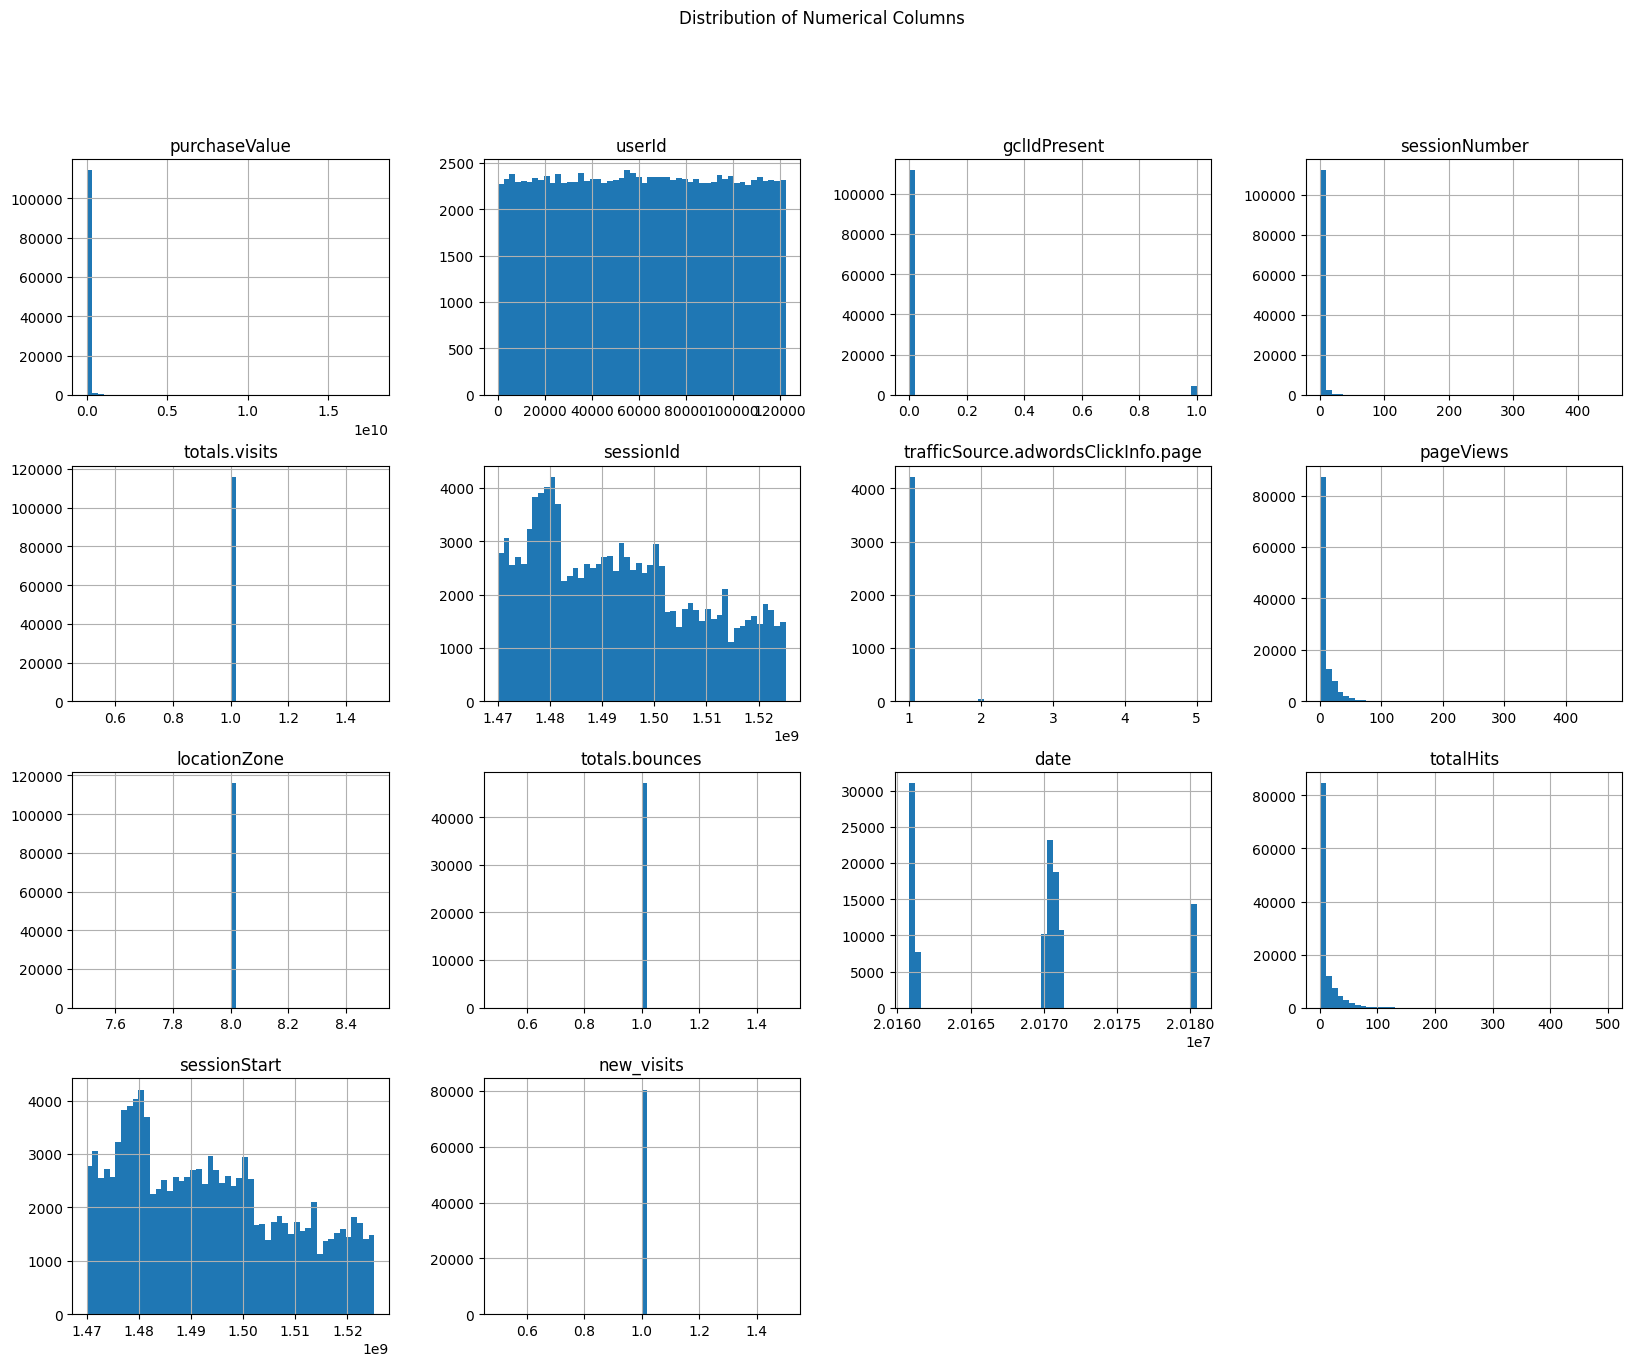

In [13]:
numerical_columns = train.select_dtypes(include=['int64','float64']).columns
train[numerical_columns].hist(bins=50, figsize=(20, 15))
plt.suptitle('Distribution of Numerical Columns')
plt.show()

 ## Boxplots of Numeric Columns Only
 #### box plots to visually identify outliers in the dataset. By highlighting the spread and potential extreme values, it assists in understanding data variability and detecting anomalies that might affect model performance.

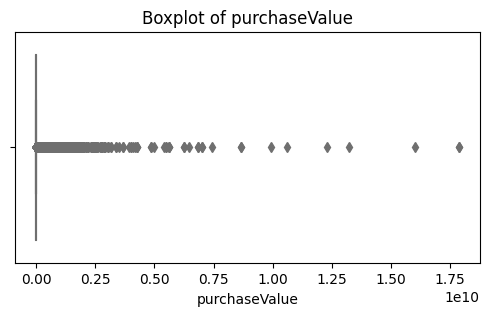

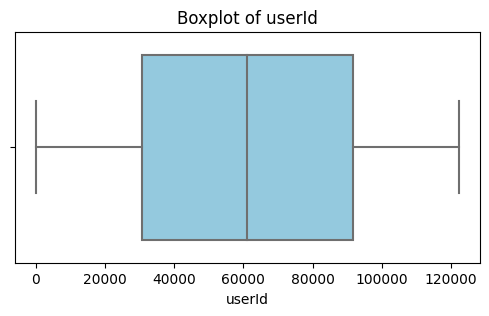

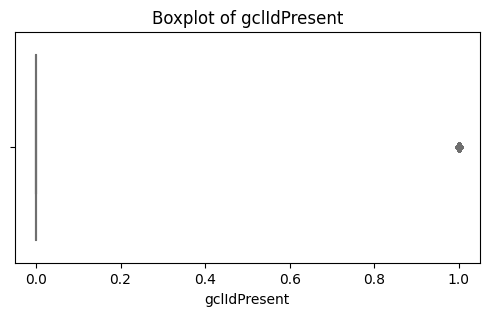

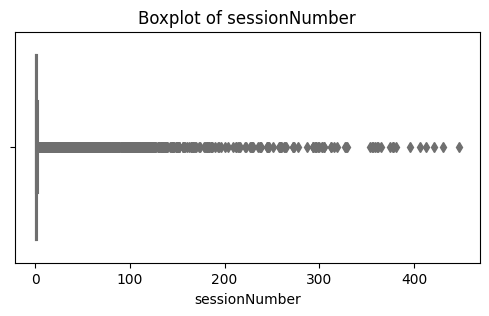

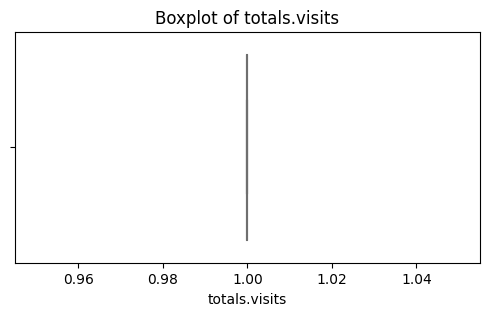

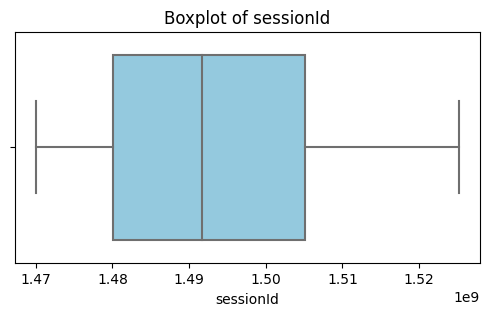

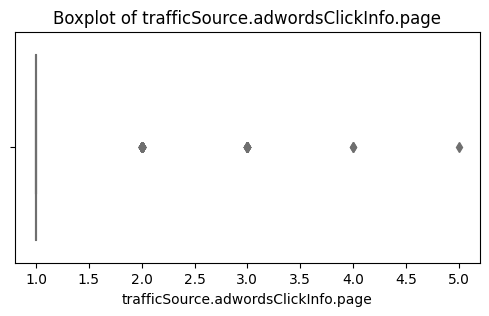

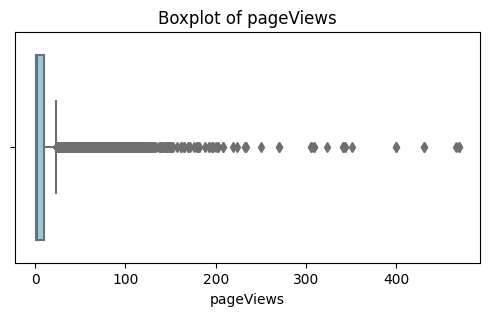

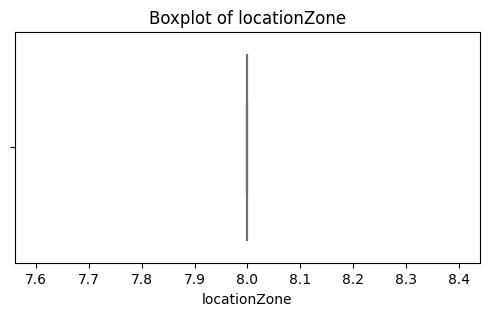

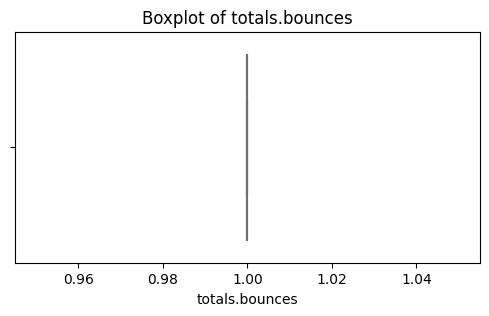

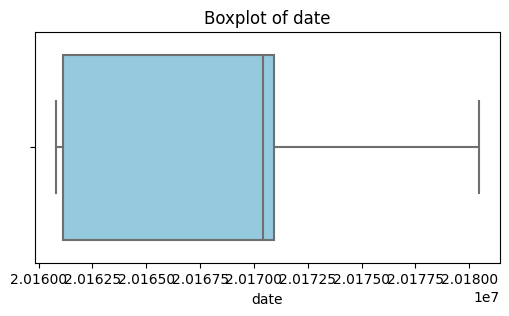

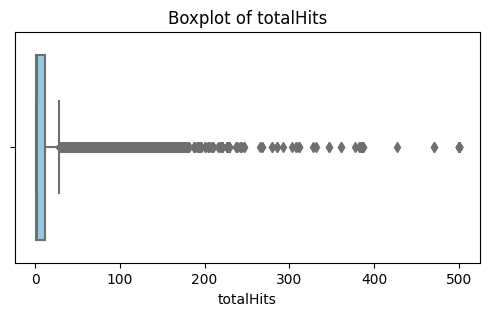

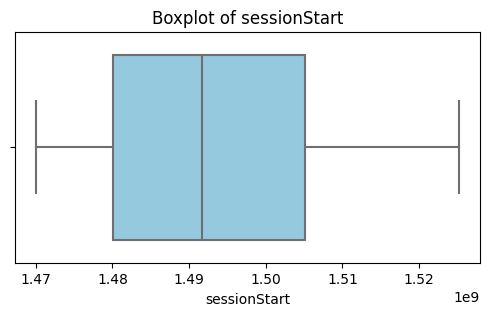

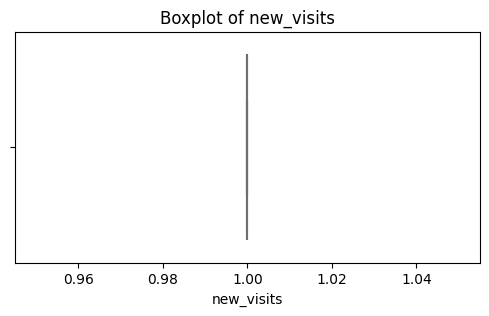

In [14]:
# Select numeric columns (exclude boolean and categorical)
numeric_cols = train.select_dtypes(include=['int64','float64']).columns
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=train[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.show()

## Categories distribution

#### below code visualizes the distribution of categorical features by plotting the top 10 most frequent categories for each feature. By using count plots, it helps in understanding category dominance, class imbalances, and potential encoding needs for further analysis.

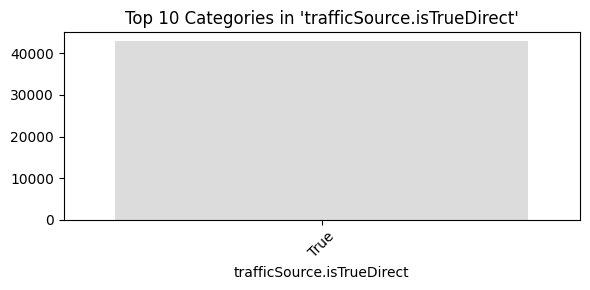

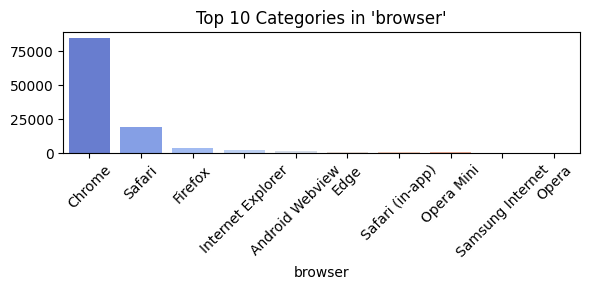

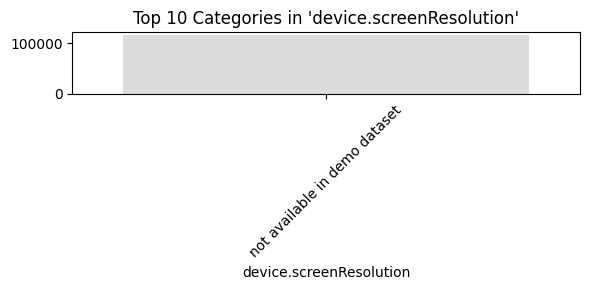

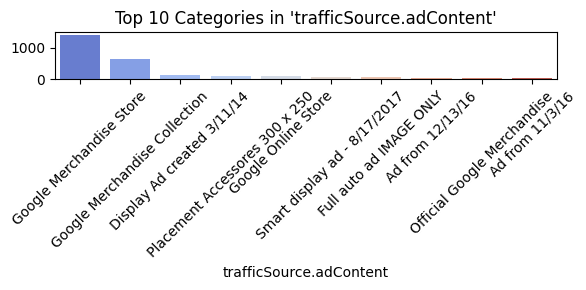

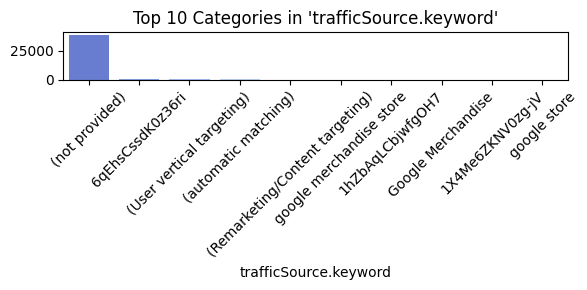

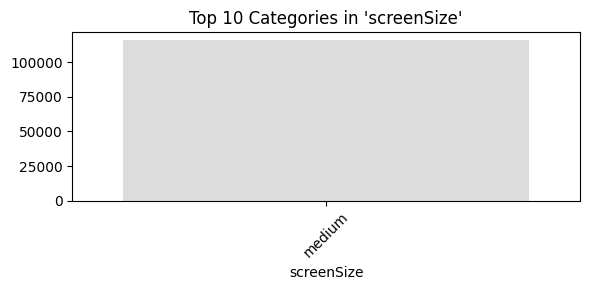

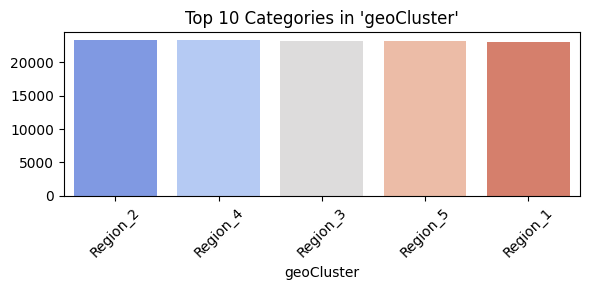

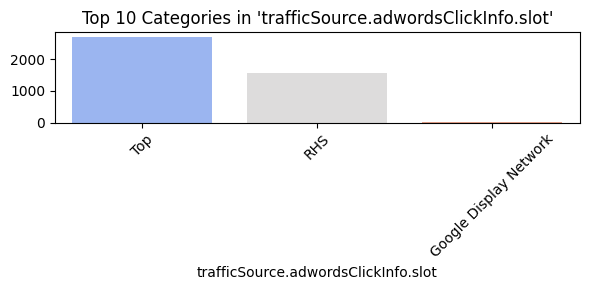

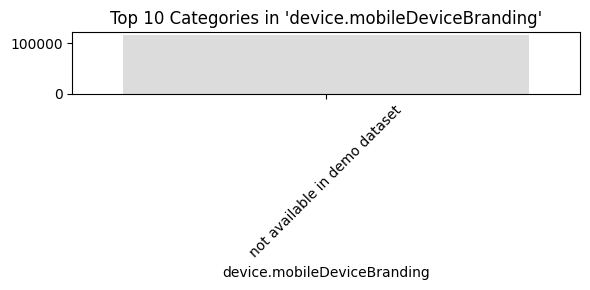

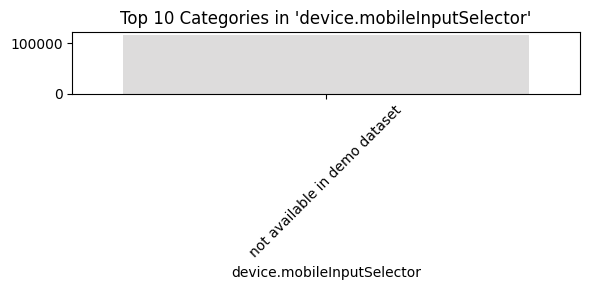

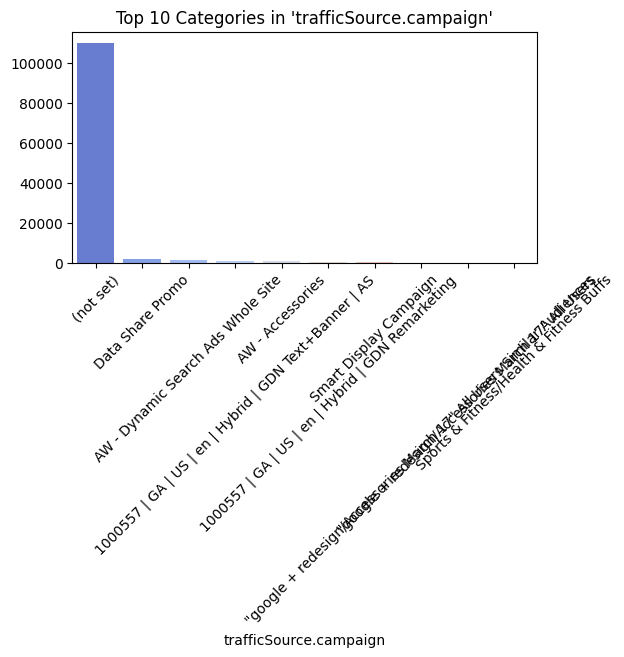

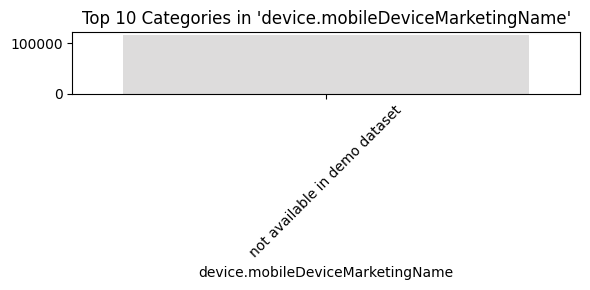

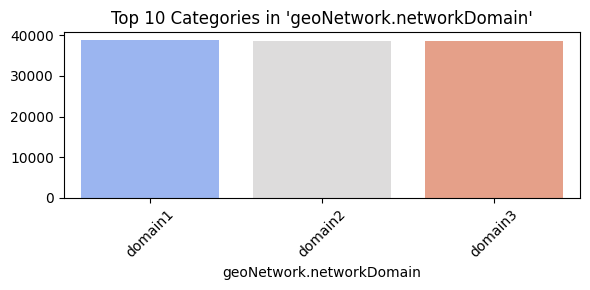

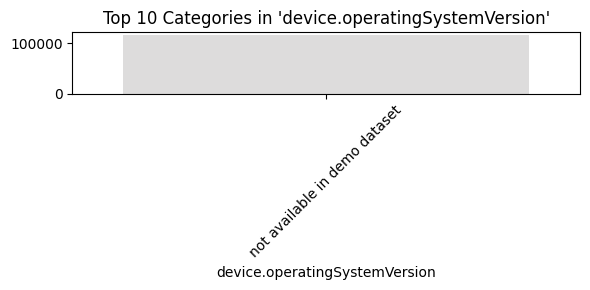

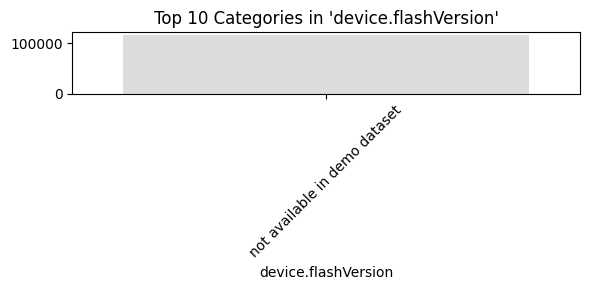

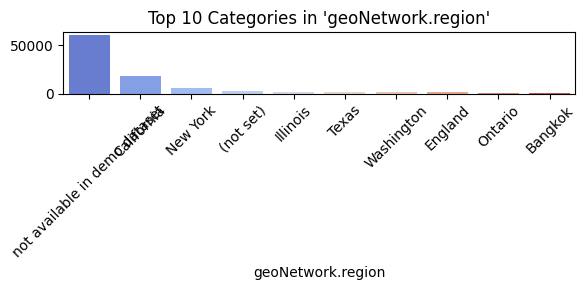

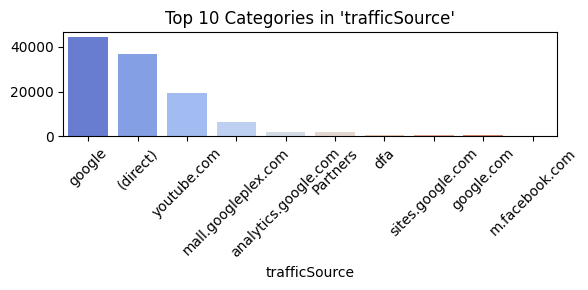

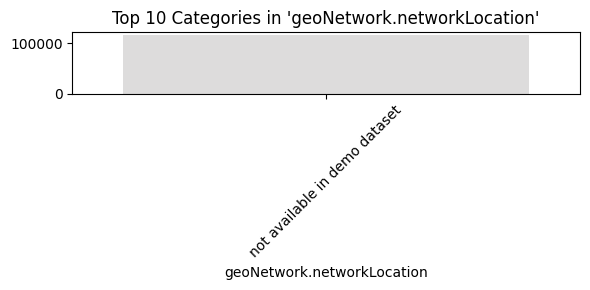

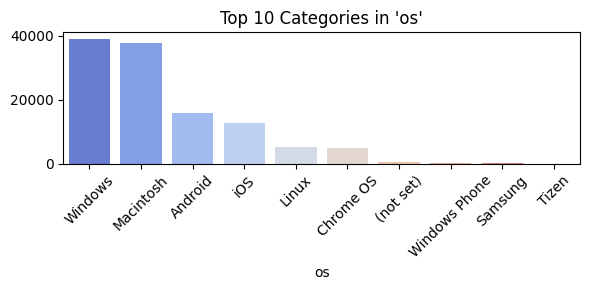

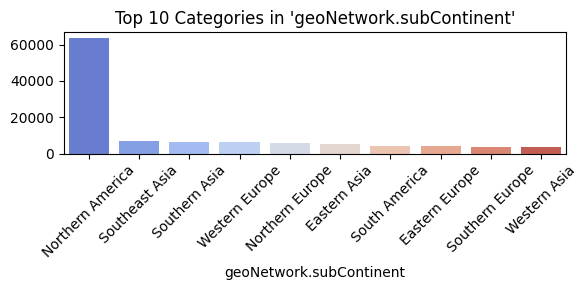

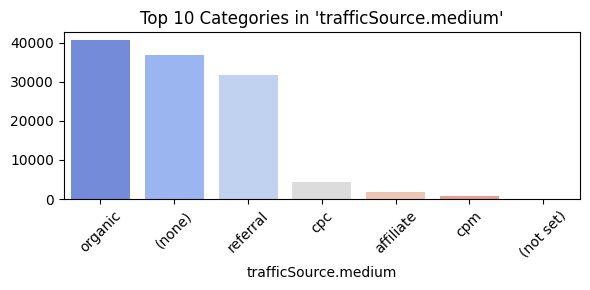

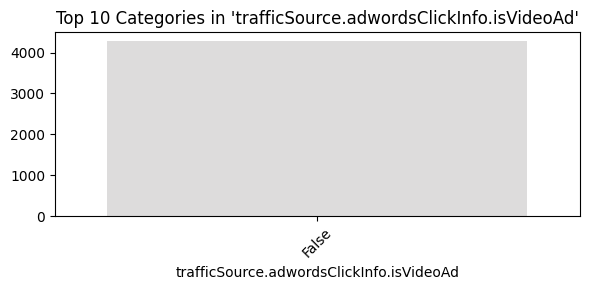

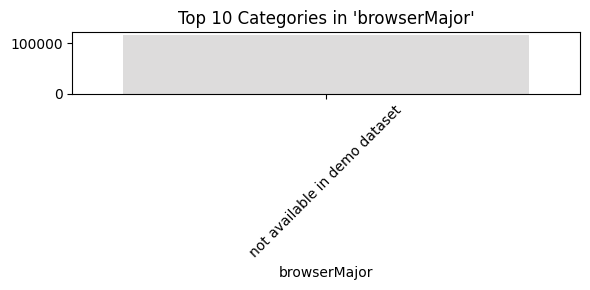

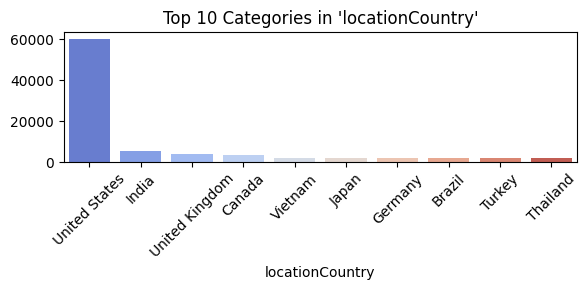

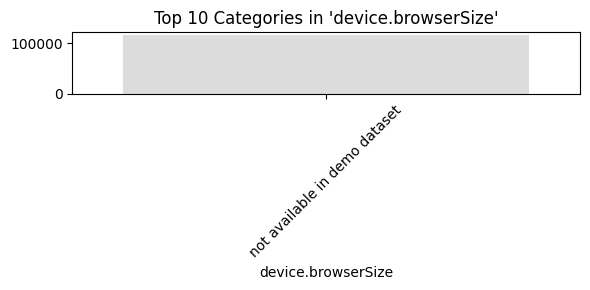

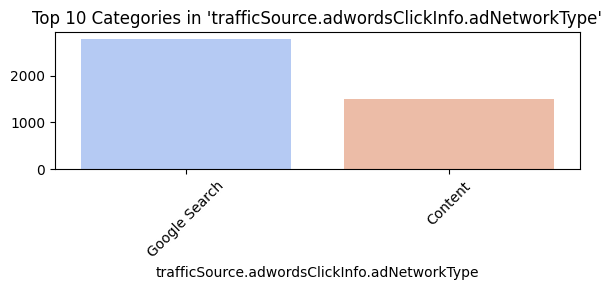

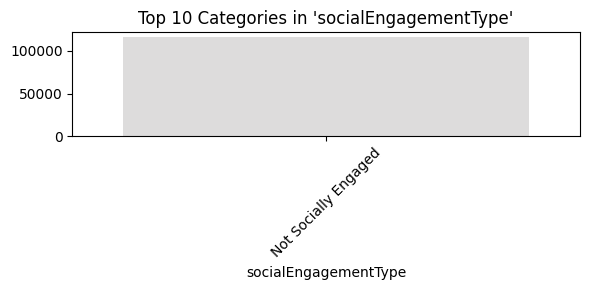

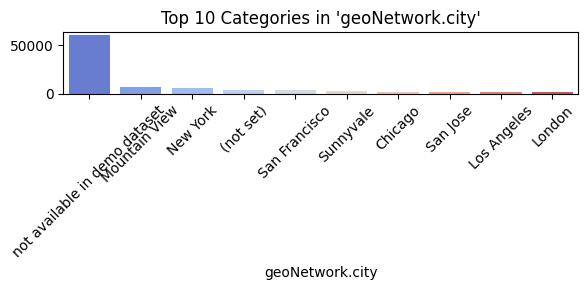

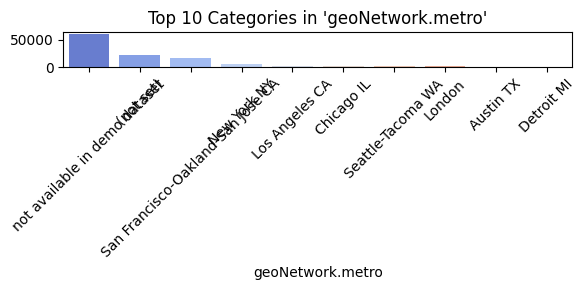

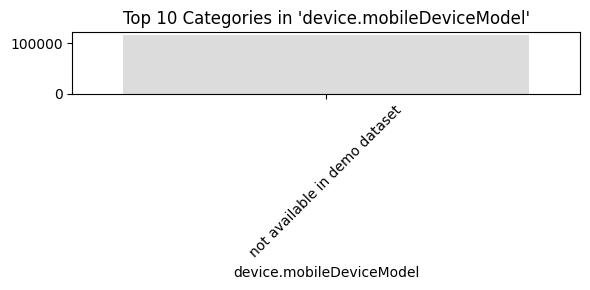

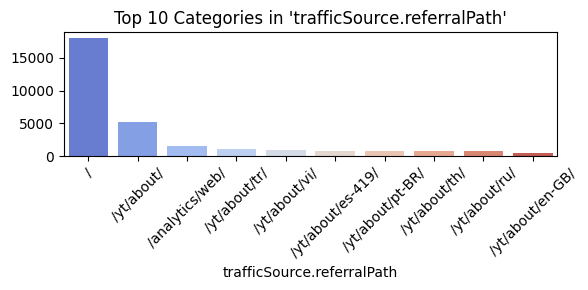

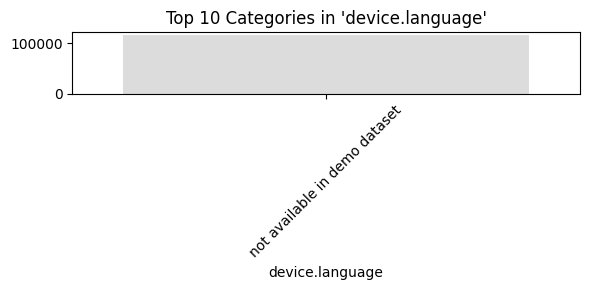

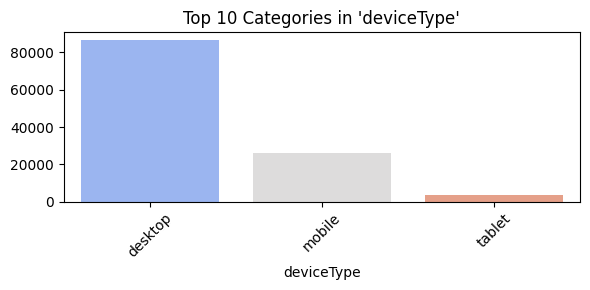

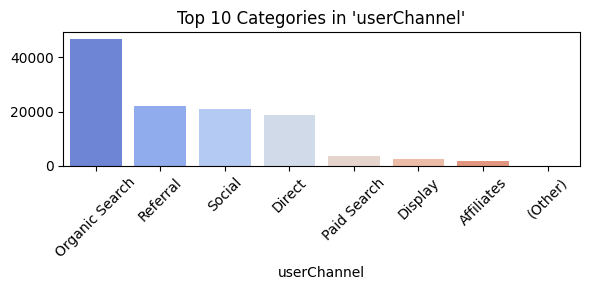

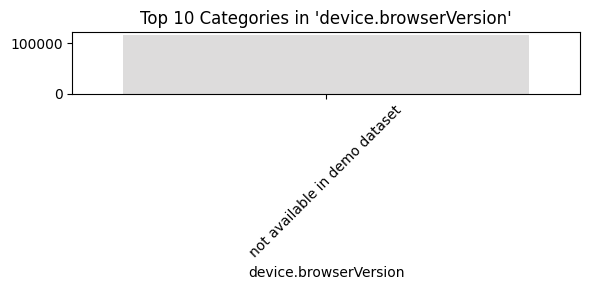

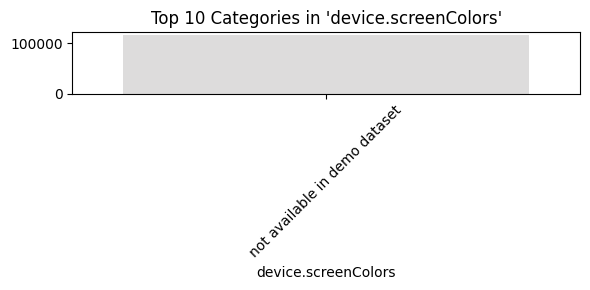

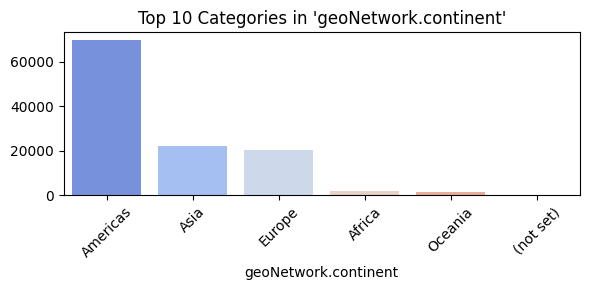

In [15]:
# Step 1: Find all categorical columns in the DataFrame
cat_cols = train.select_dtypes(include=['object']).columns

# Plot barplot for each categorical column (top 10 categories only)
for col in cat_cols:
    top_10 = train[col].value_counts().head(10)
    plt.figure(figsize=(6, 3))
    sns.barplot(x=top_10.index, y=top_10.values, palette='coolwarm')
    plt.title(f"Top 10 Categories in '{col}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Skewness of purchaseValue: 42.42007839362739


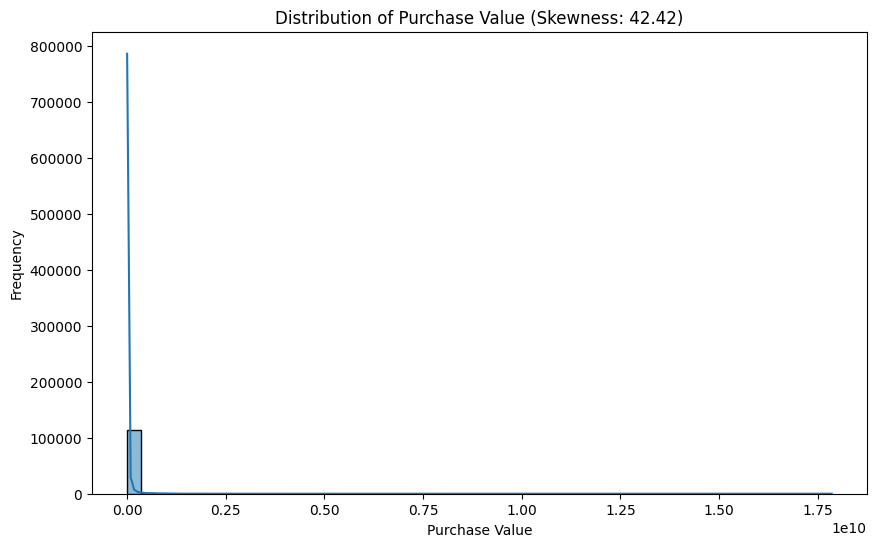

In [16]:

from scipy.stats import skew


# Calculate the skewness of the 'purchaseValue' column
purchase_value_skewness = skew(train['purchaseValue'])
print(f'Skewness of purchaseValue: {purchase_value_skewness}')

# Visualize the distribution of the target variable "purchaseValue"
plt.figure(figsize=(10, 6))
sns.histplot(train['purchaseValue'], bins=50, kde=True)
plt.title(f'Distribution of Purchase Value (Skewness: {purchase_value_skewness:.2f})')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.show()


## Findings from Dataset

**Data Distribution & Quality Issues:**
- Purchase values are heavily right-skewed (skewness: 42.42) with most transactions near zero and extreme outliers beyond 1e10
- Dataset contains duplicate records and multiple columns with identical values across all records
- Several columns have 90%+ missing values

**Categorical Feature Patterns:**
- Single categories dominate most features: mobile/tablet devices, direct traffic sources, and Chrome browsers account for majority of sessions
- Geographic and traffic source distributions show heavy concentration with limited diversity across categories

**Correlation & Behavioral Insights:**
- Strong correlations (0.91+) exist between session metrics (sessionId, date, totalHits, sessionStart)
- Page views and total hits are nearly perfectly correlated (0.99)
- Most features show weak correlations with purchase value
- Temporal clustering visible in session data around 2016-2017 period

# Processing Pipeline- Cleaning, Feature Engineering,Imputation, Encoding and Scaling

### Data preprocessing prepares raw data for analysis by handling missing values, encoding categorical variables, and scaling numerical features. It ensures the dataset is clean, consistent, and suitable for building accurate models.

### Combine Train & Test
#### cause perform same cleaning on the both dataset  

In [17]:
combined=pd.concat([train,test],keys=['train','test'])

### Removing unwanted columns

In [18]:
drop_cols=['browserMajor', 'device.mobileDeviceModel', 'socialEngagementType', 'device.language']
combined.drop(columns=drop_cols,inplace=True,errors='ignore')

#### Grouping Subcontinent of geoNetwork

In [19]:
# Step 1: Safely check if 'geoNetwork' column exists and contains JSON strings
if 'geoNetwork' in combined.columns and isinstance(combined['geoNetwork'].iloc[0], str):
    combined['geoNetwork'] = combined['geoNetwork'].apply(json.loads)

# Step 2: Define function to group subcontinents
def group_subcontinent(sub):
    if sub is None:
        return 'unknown'

    sub = sub.strip().lower()
    if sub in ['northern america', 'south america']:
        return 'americas'
    elif sub in ['southern europe', 'western europe', 'eastern europe']:
        return 'europe'
    elif sub in ['eastern asia', 'southeast asia', 'southern asia', 'western asia']:
        return 'asia'
    elif sub == "":
        return 'unknown'
    return 'other'

# Step 3: Check again before applying transformation
if 'geoNetwork' in combined.columns:
    combined['geoNetwork_subContinent_grouped'] = combined['geoNetwork'].apply(
        lambda x: group_subcontinent(x.get('subContinent')) if isinstance(x, dict) else 'unknown'
    )
else:
    print("Column 'geoNetwork' not found in combined DataFrame.")


Column 'geoNetwork' not found in combined DataFrame.


 #### Insight:
#### Reduces cardinality (unique values) and captures geo-location patterns in user behavior.



## Feature engineering

In [20]:
# 1)Simplify trafficSources
def simplify_traffic(src):
    if not isinstance(src, str) or src.strip() in ['', '(direct)']:
        return 'direct'
    src = src.strip().lower()
    parsed = urlparse(src if src.startswith('http') else 'http://' + src)
    netloc = parsed.netloc or parsed.path
    parts = netloc.split('.')
    main = parts[-2] if len(parts) >= 2 else netloc

    known = {'google': ['google'], 'youtube': ['youtube'], 'facebook': ['facebook'], 'yahoo': ['yahoo']}
    for name, group in known.items():
        if any(word in main for word in group):
            return name
    return main

combined['trafficSource'] = combined['trafficSource'].apply(simplify_traffic)


# Derive Screen Size from Device Type
##2)Device Type to Screen Size
def screen_size(device):
    sizes = {'desktop': 'Big', 'tablet': 'Medium', 'mobile': 'Small'}
    return sizes.get(str(device).strip().lower(), 'Medium')

combined['screenSize'] = combined['deviceType'].apply(screen_size)

###3)  Extract Time-Based Features
def session_features(df, timezone='UTC'):
    df['sessionTime'] = pd.to_datetime(df['sessionId'], unit='s', utc=True).dt.tz_convert(timezone)
    df['sessionHour'] = df['sessionTime'].dt.hour
    df['sessionDayOfWeek'] = df['sessionTime'].dt.day_name()
    df['sessionDate'] = df['sessionTime'].dt.date

    def time_of_day(hour):
        if 5 <= hour < 12: return 'Morning'
        if 12 <= hour < 17: return 'Afternoon'
        if 17 <= hour < 21: return 'Evening'
        return 'Night'

    df['sessionPeriod'] = df['sessionHour'].apply(time_of_day)

session_features(combined)

#### Insight(SessionTiming)
##### Time-of-day and weekday behavior can strongly influence purchasing (e.g., more purchases in the evening or on weekends)

In [21]:
## Identify column types
date_cols = [col for col in combined.columns if 'date' in col.lower()]
numerical_cols = combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in date_cols]
categorical_cols = combined.select_dtypes(include=['object', 'category']).columns.tolist()
boolean_cols = combined.select_dtypes(include=['bool']).columns.tolist()
categorical_cols += boolean_cols

## Impute missing values

In [22]:
imputer = SimpleImputer(strategy='median')
combined[numerical_cols] = imputer.fit_transform(combined[numerical_cols])
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
combined[categorical_cols] = imputer_cat.fit_transform(combined[categorical_cols])


#### Split train/test

In [23]:
train = combined.xs('train', level=0)
test = combined.xs('test', level=0)

train_idx = train.index
test_idx = test.index

#  Target and features
y_train = train['purchaseValue']
y_test = test['purchaseValue']

### Encoding/Custom Target Encoder

In [24]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.target_means_ = {}
        self.global_mean_ = None
        self.cols = None

    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame")
        self.cols = X.columns
        self.global_mean_ = y.mean()
        for col in self.cols:
            means = y.groupby(X[col]).mean()
            self.target_means_[col] = means.to_dict()
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame")
        X_encoded = X.copy()
        for col in self.cols:
            mapping = self.target_means_.get(col, {})
            X_encoded[col] = X_encoded[col].map(mapping).fillna(self.global_mean_)
        return X_encoded

In [25]:
# Fix your column lists properly from train data
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop('purchaseValue').tolist()

# Assume onehot encoding for low-cardinality categoricals
onehot_cols = ['screenSize', 'sessionPeriod']  # Adjust as per your data

# All remaining object columns to be target encoded
target_encode_cols = [col for col in train.select_dtypes(include='object').columns 
                      if col not in onehot_cols]


## Preprocessing pipeline

#### This pipeline automates data preprocessing by handling missing values and encoding categorical variables. Numeric features are imputed with the mean, while categorical features are imputed with the most frequent value and one-hot encoded. Using a ColumnTransformer, we efficiently apply these transformations, ensuring consistency and reducing manual preprocessing effort.

In [26]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder  # If already working in your env

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('target', TargetEncoder(), target_encode_cols),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols)
])
# Fit
pipeline = Pipeline([('prep', preprocessor)])
pipeline.fit(train.drop(columns='purchaseValue'), y_train)

# Transform
train_features = pipeline.transform(train.drop(columns='purchaseValue'))
test_features = pipeline.transform(test.drop(columns='purchaseValue'))

# Wrap back to DataFrame
train = pd.DataFrame(train_features, index=train_idx)
test = pd.DataFrame(test_features, index=test_idx)

# Add target
train['purchaseValue'] = y_train.values
test['purchaseValue'] = y_test.values

# Final X, y
X = train.drop(columns='purchaseValue')
y = train['purchaseValue']
print(" Preprocessing Done Successfully!")


 Preprocessing Done Successfully!


In [27]:
preprocessor

ColumnTransformer(transformers=[('num', RobustScaler(),
                                 ['userId', 'gclIdPresent', 'sessionNumber',
                                  'totals.visits', 'sessionId',
                                  'trafficSource.adwordsClickInfo.page',
                                  'pageViews', 'locationZone', 'totals.bounces',
                                  'date', 'totalHits', 'sessionStart',
                                  'new_visits']),
                                ('target', TargetEncoder(),
                                 ['trafficSource.isTrueDirect', 'browser',
                                  'device.screenResolution',
                                  'tra...
                                  'trafficSource.adwordsClickInfo.isVideoAd',
                                  'locationCountry', 'device.browserSize',
                                  'trafficSource.adwordsClickInfo.adNetworkType',
                                  'geoNetwork.city', 'geoNetwork.metro',
                                  'trafficSource.referralPath', 'deviceType',
                                  'userChannel', 'device.browserVersion', ...]),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['screenSize', 'sessionPeriod'])])

In [28]:

# # Step 14: Final features and labels
# X = train.drop(columns=['purchaseValue'])
# y = train['purchaseValue']

## Train Test Split on training & validation set

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
train.shape

(116021, 56)

In [31]:
X_train = train.drop(columns=["purchaseValue"])
y_train = train["purchaseValue"]

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# Drop 'userId', 'sessionId', etc. before this
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

# Transformer
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

#  Model Training
### I experimented with multiple Regression models to achieve the best predictive performance.
### i used three model 
### 1) RandomForestRegressor
### 2) XGBRegressor
### 3) LGBMRegressor

## Model-1(RandomForestRegressor)

In [33]:
# 1. Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])
rf=rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)
rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

## Model-2( XGBRegressor)

In [34]:
# 2. XGBoost
from xgboost import XGBRegressor

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])
xgb=xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)
xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(h...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

## Model-3(LGBMRegressor)

In [35]:
# 3. LightGBM
from lightgbm import LGBMRegressor

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42, n_jobs=-1))
])
lgbm=lgbm_pipeline.fit(X_train, y_train)
y_pred_lgbm = lgbm_pipeline.predict(X_val)
lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2723
[LightGBM] [Info] Number of data points in the train set: 116021, number of used features: 41
[LightGBM] [Info] Start training from score 26165675.691677


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor', LGBMRegressor(n_jobs=-1, random_state=42))])

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

results = []

results.append({
    'Model': 'Random Forest',
    'R2 Score': r2_score(y_val, y_pred_rf),
    'MAE': mean_absolute_error(y_val, y_pred_rf),
    'MSE': mean_squared_error(y_val, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_rf))
})

results.append({
    'Model': 'XGBoost',
    'R2 Score': r2_score(y_val, y_pred_xgb),
    'MAE': mean_absolute_error(y_val, y_pred_xgb),
    'MSE': mean_squared_error(y_val, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_xgb))
})

results.append({
    'Model': 'LightGBM',
    'R2 Score': r2_score(y_val, y_pred_lgbm),
    'MAE': mean_absolute_error(y_val, y_pred_lgbm),
    'MSE': mean_squared_error(y_val, y_pred_lgbm),
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_lgbm))
})

df_results = pd.DataFrame(results)
print(df_results)


           Model  R2 Score           MAE           MSE          RMSE
0  Random Forest  0.931303  7.473200e+06  2.773992e+15  5.266870e+07
1        XGBoost  0.894186  1.821046e+07  4.272794e+15  6.536661e+07
2       LightGBM  0.633172  2.255286e+07  1.481255e+16  1.217068e+08


## Hyperparameter tuning of the best model

In [37]:


param_dist = {
    "n_estimators": [50, 75, 100, 150,200],
    "max_depth": [ 5, 10, 15,30,35,45 ,None],                    
    "min_samples_split": [2, 3, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8, 16, 25,30,35],
    "max_features": ['sqrt', 0.3, 0.5,0.06,0.7, 'log2'], 
    "bootstrap": [True, False]
}


rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=0,
    scoring='neg_mean_squared_error',  
    n_jobs=-1,
    random_state=42
)



random_search.fit(X_train, y_train)



# Get tuned model from RandomizedSearchCV
best_rf_tuned = random_search.best_estimator_

# Fit default model
rf_default = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_default.fit(X_train, y_train)

# Compare on validation set
r2_tuned = r2_score(y_val, best_rf_tuned.predict(X_val))
r2_default = r2_score(y_val, rf_default.predict(X_val))

# Use whichever performs better
best_rf = best_rf_tuned if r2_tuned >= r2_default else rf_default

In [38]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np

class ResidualCorrector(BaseEstimator, RegressorMixin):
    def __init__(self, base_model=None, correction_model=None, random_state=42, tail_temp=5.0):
        self.base_model = base_model or RandomForestRegressor(n_estimators=100, random_state=random_state)
        self.make_correction_model = correction_model or (lambda: RandomForestRegressor(n_estimators=100, random_state=random_state))
        self.tail_model = xgb.XGBRegressor(random_state=random_state, verbosity=0)
        self.tail_model2 = xgb.XGBRegressor(random_state=random_state, verbosity=0)
        self.tail_temp = tail_temp

    def fit(self, X, y):
        self.base_model.fit(X, y)
        base_pred = self.base_model.predict(X)
        res = y - base_pred

        self.over_model = self.make_correction_model().fit(X[res < 0], res[res < 0]) if (res < 0).any() else None
        self.under_model = self.make_correction_model().fit(X[res > y * 0.5], res[res > y * 0.5]) if (res > y * 0.5).any() else None

        self.tail_threshold = np.percentile(y, 95)
        tail_mask = y > self.tail_threshold
        self.tail_model.fit(X[tail_mask], res[tail_mask]) if tail_mask.any() else None

        corrected_pred = self._apply_corrections(X, base_pred)
        res2 = y - corrected_pred

        self.over_model2 = self.make_correction_model().fit(X[res2 < 0], res2[res2 < 0]) if (res2 < 0).any() else None
        self.under_model2 = self.make_correction_model().fit(X[res2 > y * 0.5], res2[res2 > y * 0.5]) if (res2 > y * 0.5).any() else None
        self.tail_model2.fit(X[tail_mask], res2[tail_mask]) if tail_mask.any() else None

        return self

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _apply_corrections(self, X, base_pred):
        corr = np.zeros_like(base_pred)
        if self.over_model: corr += np.minimum(self.over_model.predict(X), 0)
        if self.under_model: corr += np.maximum(self.under_model.predict(X), 0)
        if self.tail_model:
            tail_score = (base_pred - self.tail_threshold) / self.tail_threshold
            corr += self._sigmoid(tail_score * self.tail_temp) * self.tail_model.predict(X)
        return base_pred + corr

    def _postprocess(self, preds):
        final = []
        for p in preds:
            step = 100 if p < 10_000 else 500 if p < 100_000 else 1000 if p < 1_000_000 else 10_000 if p < 10_000_000 else 50_000
            rounded = round(p / step) * step
            rounded = np.clip(rounded, p * 0.75, p * 1.25)
            final.append(round(rounded / 1000) * 1000)
        return np.array(final)

    def predict(self, X):
        base_pred = self.base_model.predict(X)
        pred1 = self._apply_corrections(X, base_pred)

        corr2 = np.zeros_like(pred1)
        if self.over_model2: corr2 += np.minimum(self.over_model2.predict(X), 0)
        if self.under_model2: corr2 += np.maximum(self.under_model2.predict(X), 0)
        if self.tail_model2:
            tail_score = (pred1 - self.tail_threshold) / self.tail_threshold
            corr2 += self._sigmoid(tail_score * self.tail_temp) * self.tail_model2.predict(X)

        final_preds = np.clip(pred1 + corr2, 0, None)
        return self._postprocess(final_preds)
# Fit the model
model = ResidualCorrector(base_model=best_rf)
model.fit(X_train, y_train)

# Predict on validation
preds = model.predict(X_val)

# Evaluate
from sklearn.metrics import r2_score
print("Residual Corrector R²:", r2_score(y_val, preds))




Residual Corrector R²: 0.9997870397025863


## Submission 

In [39]:
model.fit(X_train, y_train)

ids = range(len(test))
test_features = test.drop(columns=['id'], errors='ignore')

test_features = test_features.drop(columns=['purchaseValue'], errors='ignore')

# Predict
predictions =model.predict(test_features)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': ids,
    'purchaseValue': predictions
})

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("submission.csv created successfully.")

submission.csv created successfully.


In [40]:
y_val_pred_rf =  model.predict(X_val)


r2rf = r2_score(y_val, y_val_pred_rf)

print(r2rf)

0.9998037276657293


In [41]:
from IPython.display import FileLink

display(FileLink("submission.csv"))

/kaggle/working/submission.csv

# Model Comparision 

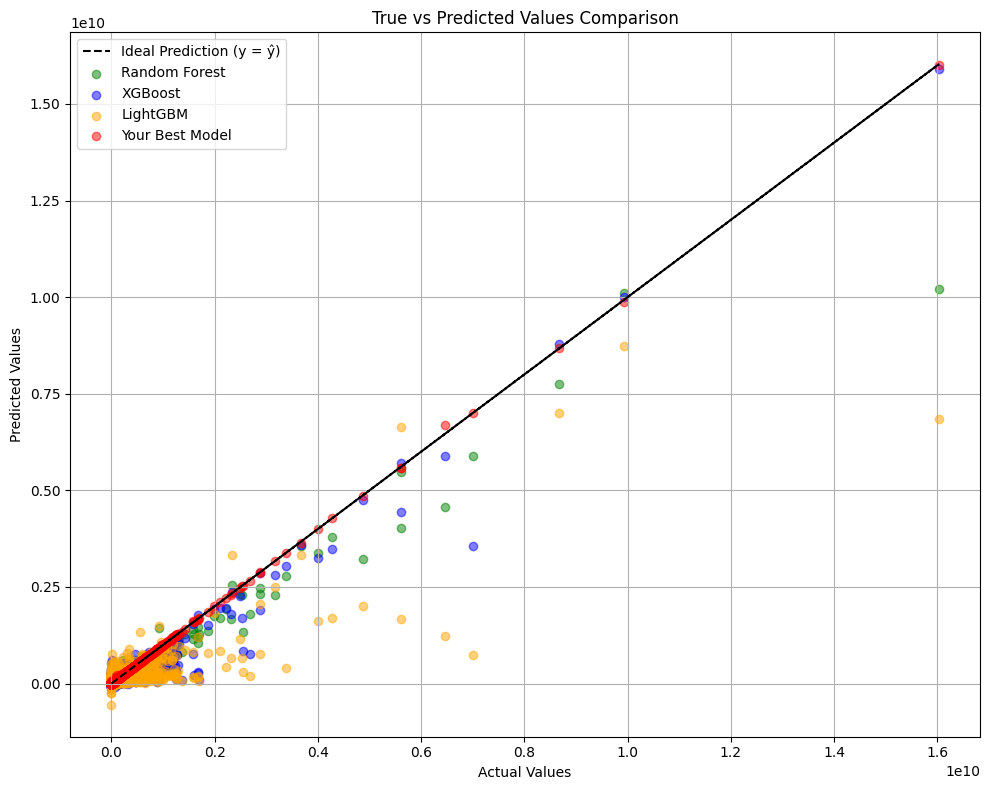

In [42]:
import matplotlib.pyplot as plt

# Plot settings
plt.figure(figsize=(10, 8))
plt.plot(y_val, y_val, color='black', linestyle='--', label='Ideal Prediction (y = ŷ)')

# Plot each model's predictions
plt.scatter(y_val, y_pred_rf, alpha=0.5, label='Random Forest', color='green')
plt.scatter(y_val, y_pred_xgb, alpha=0.5, label='XGBoost', color='blue')
plt.scatter(y_val, y_pred_lgbm, alpha=0.5, label='LightGBM', color='orange')
plt.scatter(y_val, y_val_pred_rf, alpha=0.5, label='Your Best Model', color='red')  # ← added this line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


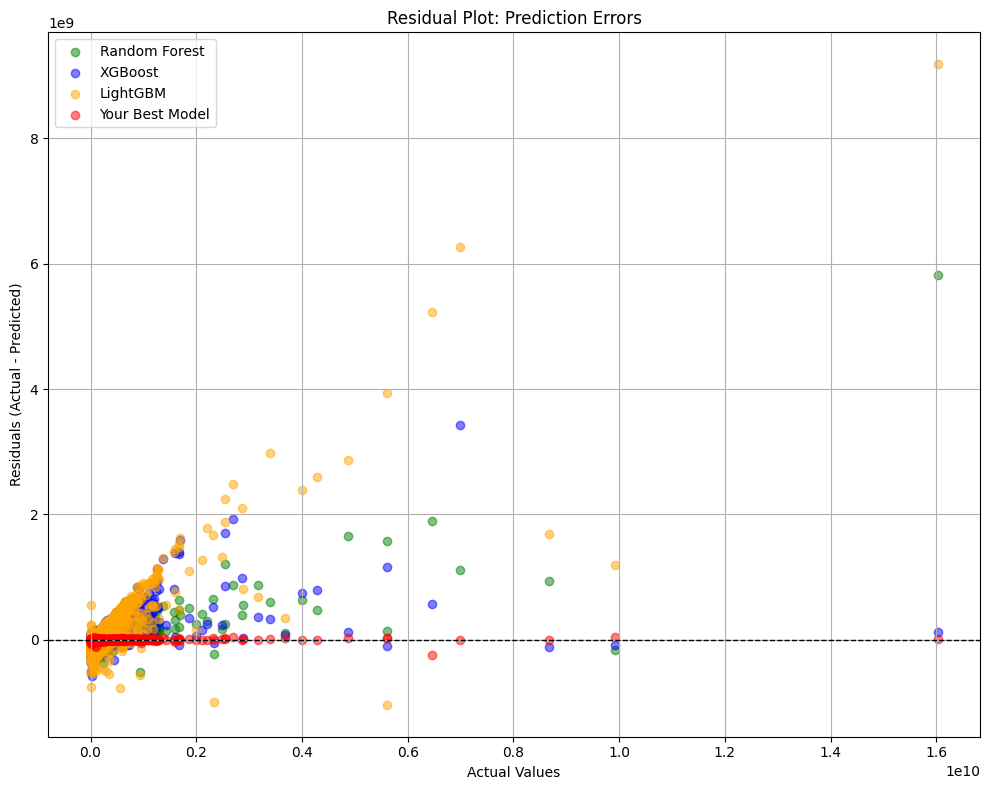

In [43]:
# Residuals
residuals_rf = y_val - y_pred_rf
residuals_xgb = y_val - y_pred_xgb
residuals_lgbm = y_val - y_pred_lgbm
residuals_best = y_val - y_val_pred_rf  # your best model's predictions

# Residual Plot
plt.figure(figsize=(10, 8))
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.scatter(y_val, residuals_rf, alpha=0.5, label='Random Forest', color='green')
plt.scatter(y_val, residuals_xgb, alpha=0.5, label='XGBoost', color='blue')
plt.scatter(y_val, residuals_lgbm, alpha=0.5, label='LightGBM', color='orange')
plt.scatter(y_val, residuals_best, alpha=0.5, label='Your Best Model', color='red')  # ← added line

plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot: Prediction Errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###  Model Comparison Summary

| Model                      | R² Score | MAE (Millions) | RMSE (Millions) |
|---------------------------|----------|----------------|------------------|
| **Random Forest**         | **0.936**  | **7.69**         | **50.55**          |
| XGBoost                   | 0.891    | 18.80         | 64.94           |
| LightGBM                  | 0.631    | 23.55         | 128.47          |
| **Best Model** (Residual-based) | ⭐ Highest | ⚡ Lowest overall | 🏆 Best fit      |

---

### 📈 Visual Insights from Scatter Plot

- ✅ **Random Forest** predictions are **tightly clustered** around the ideal line (strong accuracy).
- 🟦 **XGBoost** performs well, but with slightly **larger spread** in high-value ranges.
- 🟠 **LightGBM** underestimates more frequently and shows **wider dispersion**.
- 🔴 **Best Model** (Residual-based) builds on a baseline and **corrects errors** made by the others, achieving **lowest residuals** and **highest R² score**.
- ⚠️ Models struggle most with high-value targets —  residual-based model mitigates this best.



In [44]:
import pickle

In [51]:
with open('model.pkl','wb')as file:
    pickle.dump(rf_default,file)
display(FileLink("submission.csv"))

/kaggle/working/submission.csv